In [17]:
import os

In [18]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # dataset
import matplotlib.pyplot as plt

In [19]:
# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate

if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True

In [20]:
# download data
train_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=True, # training data
    transform=torchvision.transforms.ToTensor(), # Converts a PIL.Image or numpy.ndarray; torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST

)

torch.Size([60000, 28, 28])
torch.Size([60000])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


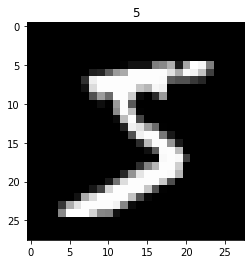

In [21]:
# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [22]:
# load training data
train_loader = Data.DataLoader(dataset=train_data,shuffle=True,batch_size=BATCH_SIZE,num_workers=2)

In [23]:
# load test data
#################### Change Here ########################
test_data = torchvision.datasets.MNIST(root='./mnist',train=False)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000].cuda()/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000].cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [24]:
# Define CNN
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()  # (1,28,28)
    # Convolusion layer 1: 2D fileter -> activation function -> pooling layer
    self.conv1 = nn.Sequential(
        nn.Conv2d(
            in_channels=1, # input height; 1 for black and white photos
            out_channels=16, # n_filters; 16 filters working simutaneously
            kernel_size=5,   # filter size; 5x5 pixels
            stride=1,    # filter movement/step
            padding=2,    # padding=(kernel_size-1)/2 if stride=1
        ),  # -> (16,28,28)
        nn.ReLU(),  # -> (16,28,28)
        nn.MaxPool2d(kernel_size=2),  # 2x2 -> (16,14,14)
    )
    self.conv2 = nn.Sequential( # (16,14,14)
        nn.Conv2d(16,32,5,1,2), # -> (32,14,14)
        nn.ReLU(),  # -> (32,14,14)
        nn.MaxPool2d(2) # -> (32,7,7)
    )
    self.out = nn.Linear(32*7*7, 10)
  
  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x) # (batch, 32, 7, 7)
    x = x.view(x.size(0),-1)  # (batch, 32x7x7)
    output = self.out(x)
    return output

In [25]:
cnn = CNN()
############## Change Here ####################
cnn.cuda()
##################################################
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [26]:
optimizer = torch.optim.Adam(params=cnn.parameters(),lr=LR)
loss_func = nn.CrossEntropyLoss()

In [27]:
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        ################### Change Here #########################
        b_x = b_x.cuda()
        b_y = b_y.cuda()
        #############################################################
        output = cnn(b_x)               # cnn output
        
        loss = loss_func(output, b_y)   # cross entropy loss

        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output = cnn(test_x)
            ############# Change Here #############
            pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()
            ##########################################
            accuracy = sum(pred_y == test_y) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 2.2961 | test accuracy: 0.12
Epoch:  0 | train loss: 0.4927 | test accuracy: 0.81
Epoch:  0 | train loss: 0.3551 | test accuracy: 0.87
Epoch:  0 | train loss: 0.2424 | test accuracy: 0.90
Epoch:  0 | train loss: 0.2132 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0882 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1735 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0729 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1130 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1505 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1000 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0907 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1015 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1671 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0608 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1196 | test accuracy: 0.97
Epoch:  0 | train loss: 0.2510 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0175 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0060 | test accuracy

In [30]:
test_output = cnn(test_x[:10])
################## Change Here ####################
pred_y = torch.max(test_output,1)[1].cpu().data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].cpu().data.numpy(), 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
